## Competition assay and competitive exclusion in serial transfers
Competition experiments are frequently performed in the laboratory to assay, for example, the fitness of a mutant in competition to the wild-type. Here, we simulate one such experiemnt involving E. coli and a nonessential but deleterious mutation involving the deletion of the triose phosphate isomerase reaction from glycolisis. 

### Load models and create a mutant
We first load our *E. coli* "core" model and create the mutant in triose phosphate isomerase by setting both upper and lower bounds to zero. We will add both models to our `test_tube` layout. 

In [2]:
# Start by loading required packages, including the COMETS toolbox
import cometspy as c
import cobra.test
import pandas as pd
import matplotlib.pyplot as plt

# load the models and perform the mutation
wt = c.model(cobra.test.create_test_model("ecoli"))
wt.id = 'wt'
mut = c.model(cobra.test.create_test_model("ecoli"))
mut.change_bounds('TPI', 0,0)
mut.id = 'TPI_KO'

# set its initial biomass, 5e-6 gr at coordinate [0,0]
wt.initial_pop = [0, 0, 5e-8]
mut.initial_pop = [0, 0, 5e-8]

Using license file /home/djordje/gurobi.lic
Academic license - for non-commercial use only


### Create layout, add models and set up media composition
We create an empty layout ("test_tube") and set the initial nutrient supply.

In [3]:
# create an empty layout
test_tube = c.layout()

# add the models to the test tube
test_tube.add_model(wt)
test_tube.add_model(mut)

building empty layout model
models will need to be added with layout.add_model()


Set the media composition by adding glucose and the inorganic nutrients required for this model (ammonia, phosphate) and oxygen. These inorganic nutrients will be considered as "static" by the simulation, with a value of 1000 that never depletes. Considering metabolites as "static" is the way COMETS has to simulate an unlimited supply of metabolites.

In [4]:
# Add glucose to the media 
test_tube.set_specific_metabolite('glc__D_e', 0.01)

# Add typical trace metabolites and oxygen coli as static
trace_metabolites = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h_e', 'k_e', 'h2o_e', 'mg2_e',
                     'mn2_e', 'mobd_e', 'na1_e', 'ni2_e', 'nh4_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']

for i in trace_metabolites:
    test_tube.set_specific_metabolite(i, 1000)
    test_tube.set_specific_static(i, 1000)

### Set up simulation parameters
We next create a parameters object and modify needed parameters - in this case only the number of cycles the simulation runs.  

In [5]:
comp_params = c.params()
comp_params.set_param('maxCycles', 240)

### Run the simulation

Finally, we create the comets object using the above created layout and parameters, and run the competition assay. 

In [6]:
comp_assay = c.comets(test_tube, comp_params)
comp_assay.JAVA_CLASSPATH = '/home/djordje/Dropbox/COMETS_RUN/lib/jmatio.jar:/home/djordje/Dropbox/COMETS_RUN/lib/jdistlib-0.4.5-bin.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-math3-3.6.1.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-lang3-3.9.jar:/home/djordje/Dropbox/COMETS_RUN/lib/colt.jar:/home/djordje/Dropbox/COMETS_RUN/lib/concurrent.jar:/home/djordje/Dropbox/COMETS_RUN/bin/comets_2.9.3.jar:/opt/gurobi901/linux64/lib/gurobi.jar'
comp_assay.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
junit			/home/djordje/Dropbox/COMETS_RUN/lib/junit/junit-4.12.jar
hamcrest			/home/djordje/Dropbox/COMETS_RUN/lib/junit/hamcrest-core-1.3.jar
jogl_all			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/lib/jamtio.jar
jmat			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/JMatIO-041212/lib/jmatio.jar
concurrent			/home/djordje/Dropbox/COMETS_RUN/lib/colt/lib/concurrent.jar
colt			/ho

We now plot the biomasses of these two genotypes in coculture. 

Text(0,0.5,'Biomass (gr.)')

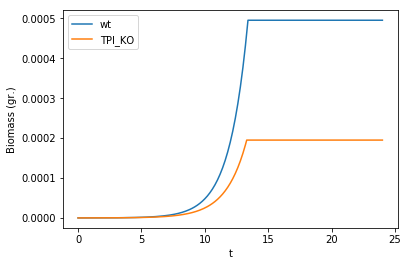

In [7]:
biomass = comp_assay.total_biomass
biomass['t'] = biomass['cycle'] * comp_assay.parameters.all_params['timeStep']

myplot = biomass.drop(columns=['cycle']).plot(x = 't')
myplot.set_ylabel("Biomass (gr.)")

We can quantitatively analyze the results. For example, we can compute the competitive fitness of the mutant respect to the wild-type as the ratio of the biomass increase of the mutant divided by that of the wild-type: 

In [8]:
cfit = (biomass.loc[biomass['t'] == 24, 'TPI_KO'].iloc[0]/biomass.loc[biomass['t'] == 0, 'TPI_KO'].iloc[0])/(biomass.loc[biomass['t'] == 24, 'wt'].iloc[0]/biomass.loc[biomass['t'] == 0, 'wt'].iloc[0])
cfit

0.39378816074777145

### Simulating serial transfers 
Using `COMETS` we can also simulate a serial tranfer competition between these two mutants. We will just modify the parameters, increasing the total simulation time and including batch transfers of 1% every 24h, but we will use the same `test_tube` layout as before. 

In [10]:
serial_params = c.params()
serial_params.set_param('maxCycles', 240*25) # simulate 4 serial transfers of 24h each
serial_params.set_param('batchDilution', True)
serial_params.set_param('dilFactor', 0.01)
serial_params.set_param('dilTime', 24)

We run the simulation 

In [11]:
serial_expt = c.comets(test_tube, serial_params)
serial_expt.JAVA_CLASSPATH = comp_assay.JAVA_CLASSPATH
serial_expt.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
junit			/home/djordje/Dropbox/COMETS_RUN/lib/junit/junit-4.12.jar
hamcrest			/home/djordje/Dropbox/COMETS_RUN/lib/junit/hamcrest-core-1.3.jar
jogl_all			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/lib/jamtio.jar
jmat			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/JMatIO-041212/lib/jmatio.jar
concurrent			/home/djordje/Dropbox/COMETS_RUN/lib/colt/lib/concurrent.jar
colt			/ho

Now plot the biomass of the two species during the experiment 

Text(0,0.5,'Biomass (gr.)')

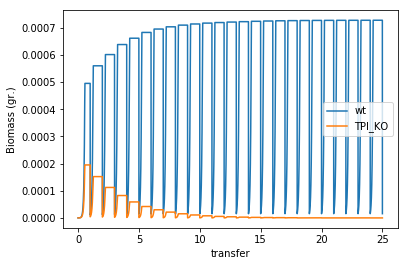

In [15]:
biomass = serial_expt.total_biomass
biomass['transfer'] = biomass['cycle'] * comp_assay.parameters.all_params['timeStep']/24

myplot = biomass.drop(columns=['cycle']).plot(x = 'transfer')
myplot.set_ylabel("Biomass (gr.)")